In [304]:
import pandas as pd # used to load individual files
import numpy as np # not currently used
import datetime as dt # not currently used
#from geopy.distance import geodesic might be used at some point
#import peartree as pt # used to construct network
import matplotlib.pyplot as plt
import osmnx as ox # visualisation library for networks
%matplotlib inline
import pickle
import networkx as nx
import geopandas as gp
from collections import defaultdict
from geopy.distance import geodesic
from tqdm import tqdm
from sklearn.neighbors import BallTree
import math
import pysal.model.spint as spint
from pysal.model.spint import Gravity
from scipy import stats
import seaborn as sns

In [3]:
with open('rejsekort_graph_cleaned.gpickle', 'rb') as f:
    G = pickle.load(f)

# Relabels nodes by removing WPDOS_ from each node
# relabel_dic = {node:node[6:] for node in G.nodes()}
# G = nx.relabel_nodes(G, relabel_dic, copy=False)



In [4]:
print(nx.number_weakly_connected_components(G))


30


In [25]:
len(ccs[1])

13456

In [37]:
# for edge in G.edges():
#     edge = G.get_edge_data(*edge)
#     print(edge)


In [5]:
set_unknown = set()
with open("data/transfers.txt") as f:
    transfers = pd.read_csv(f, sep=",",dtype=str)
    for idx in range(len(transfers)):
        line = transfers.iloc[idx]
        node1 = line.from_stop_id
        node2 = line.to_stop_id
        length = line.min_transfer_time
        if node1 not in G.nodes():
            set_unknown.add(node1)
        if node2 not in G.nodes():
            set_unknown.add(node2)    
        # G.add_edge(node1, node2, mode = 'transfer', length=length)

print(len(node2))

12


In [6]:
list(set_unknown)[2]

'000835000402'

In [7]:
len(set_unknown)

261

In [8]:
len(G.nodes())
len(G.edges)

52656

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


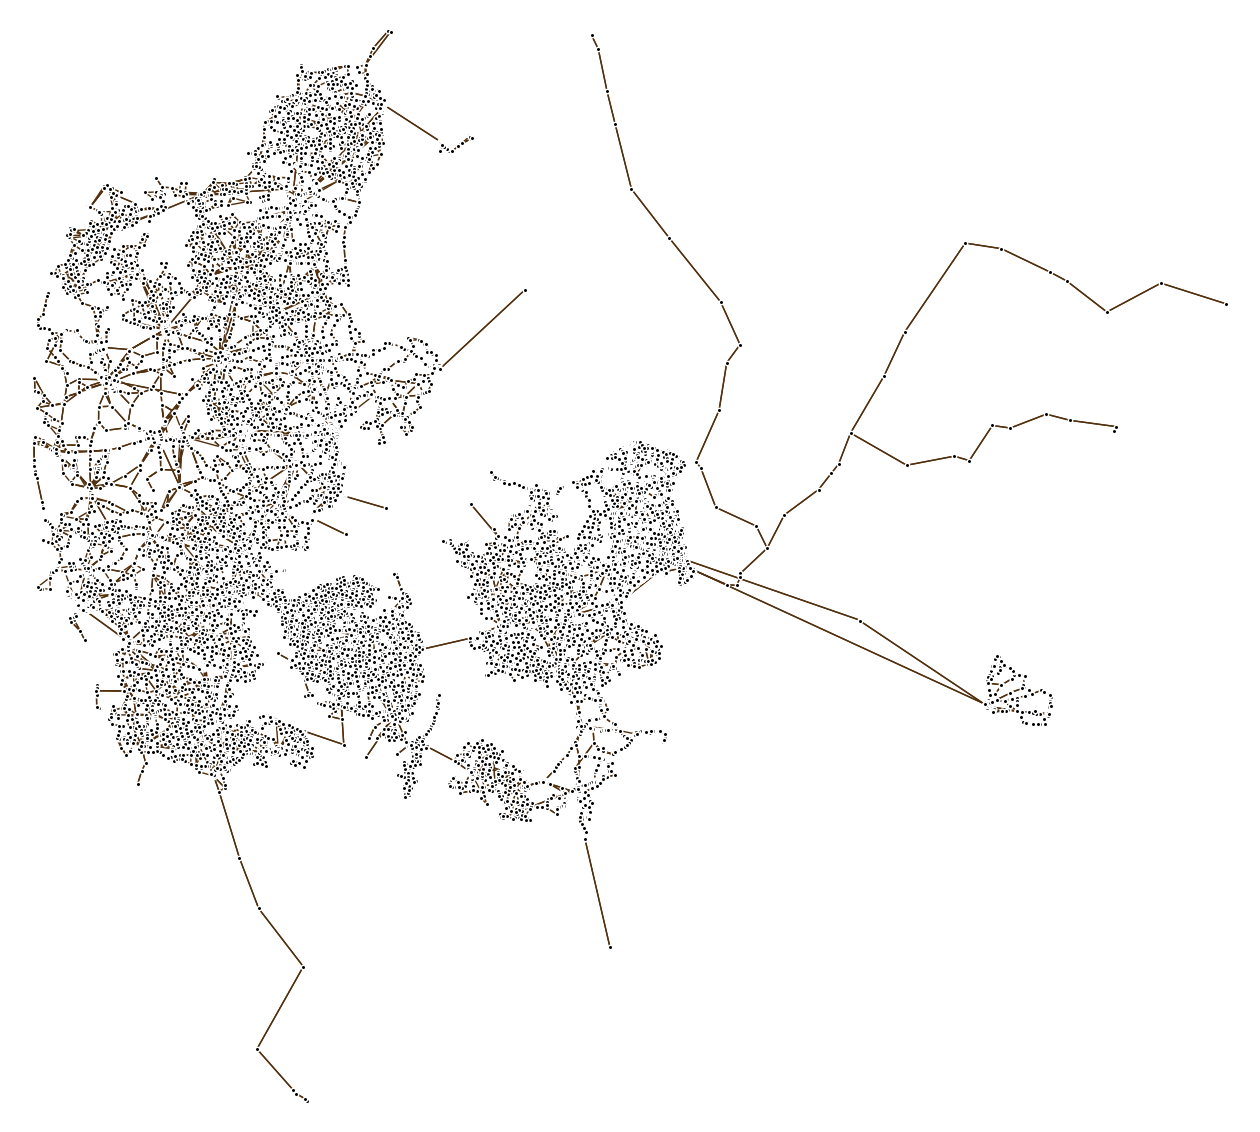

In [10]:
fig, ax = ox.plot_graph(G,
               figsize = (16,16),
                show=False,
                close=False,
                node_color='black',
                node_edgecolor="white",
                node_size=10,
                node_zorder=10,
                edge_color='#522F0D',
                edge_alpha=1,
                edge_linewidth = 1,
                bgcolor='None',
                #bbox= bbox_,
               #bgcolor='black'
              
             );

Modes of transport from GTFS reference
109 s-tog
700 bus
715 demand and response bus service
0 letbanen lightrail
1 is metro
2 train/intercity
3 localtog and bus?
4 ferry maybe other too?

Types of busses
S bus is fast and direct bus routes
e bus are express buslines during rush hour
p bus are local buses
n bus are night buses
havn bus




In [11]:
modes= [G.nodes[node]["modes"] for node in G.nodes()]
uniqmodes = set()
for mode in modes:
    uniqmodes = uniqmodes.union(set(mode))
uniqmodes

{'0', '1', '109', '2', '3', '4', '700', '715'}

In [12]:
edges = G.edges()

In [14]:
G.nodes()['000000000002']

{'boarding_cost': 1681.8,
 'modes': ['3'],
 'y': 55.767248497366,
 'x': 12.498017540594}

In [15]:
G['000000000002']

AdjacencyView({'000000000003': {0: {'length': 60.0, 'mode': 'transit'}}})

In [16]:
mode_counts=defaultdict(int)
for edge in G.edges():
    edge = G.get_edge_data(*edge)
    mode_counts[edge[0]['mode']] += 1
print(mode_counts)

defaultdict(<class 'int'>, {'transit': 52656})


In [2]:
def tacicab_sphere(latlong1,latlong2):
    '''
    Returns the taxicab distance between two points on a sphere (given lat-long pairs).
    Formula: http://cs.ucmo.edu/~mjms/2005.1/bayar.pdf
    '''
    x1,y1 = latlong1
    x2,y2 = latlong2
    return min(
        geodesic((x1,y1),(x2,y1)).meters + geodesic((x2,y1),(x2,y2)).meters,
        geodesic((x1,y1),(x1,y2)).meters + geodesic((x1,y2),(x2,y2)).meters
    )

def m2s(m):
    return m/1.25 #Walking speed used by Google Maps

# Conversion function for input to BallTree
def convert_latlon_to_balltree_input(lat, lon):
    return np.vstack([np.radians(lon), np.radians(90-np.array(lat))]).T

In [18]:
''' Bad Code
def add_walk_edges(G):
    G = G.copy()
    for node1 in tqdm(G.nodes()):
        for node2 in G.nodes():
            if node1 == node2:
                continue
            for (u,v,edge_type) in G.edges(node1, data="mode"):
                if v == node2 and edge_type in {"transfer","walk"}:
                    break
            else:
                walk_time = m2s(tacicab_sphere((G.nodes[node1]["x"],G.nodes[node1]["y"]),(G.nodes[node2]["x"],G.nodes[node2]["y"])))
                if walk_time <= 30*60 or node2 in G.neighbors(node1): #If less than x time away or transit edge (non-walk, non-transfer neigbor-edges)
                    G.add_edge(node1, node2, routes = {}, trips = {}, mode = 'walk', weight=max(walk_time,180))
    return G.
'''

In [40]:
# Good code
def add_walk_edges(G):
    G = G.copy()
    node_positions = convert_latlon_to_balltree_input([G.nodes[node]["y"] for node in G.nodes()], [G.nodes[node]["x"] for node in G.nodes()])
    balltree = BallTree(node_positions, metric='haversine')

    for idx1, node1 in enumerate(tqdm(G.nodes())):
        node1_position = convert_latlon_to_balltree_input([G.nodes[node1]["y"]], [G.nodes[node1]["x"]])
        
        # Use the BallTree to find all nodes within 1 km
        # Divide by the Earth's radius, which is approximately 6371 kilometres, to convert to radians
        close_nodes = balltree.query_radius(node1_position, r=1.0 / 6371)
        close_nodes = close_nodes[0]  # query_radius returns a list of arrays, we are interested in the first array

        for idx2 in close_nodes:
            node2 = list(G.nodes())[idx2]
            if node1 == node2:
                continue
            for (u,v,edge_type) in G.edges(node1, data="mode"):
                if v == node2 and edge_type in {"transfer","walk"}:
                    break
            else:
                walk_time = m2s(tacicab_sphere((G.nodes[node1]["x"],G.nodes[node1]["y"]),(G.nodes[node2]["x"],G.nodes[node2]["y"])))
                if walk_time <= 30*60 or node2 in G.neighbors(node1): #If less than x time away or transit edge (non-walk, non-transfer neigbor-edges)
                    G.add_edge(node1, node2, routes = {}, trips = {}, mode = 'walk', weight=max(walk_time,180))
    return G

In [41]:
#G_walks = add_walk_edges(G)

100%|█████████████████████████████████████████████████████████████████████████████| 38172/38172 [15:40<00:00, 40.61it/s]


In [53]:
#with open('G_walks.pkl', 'wb') as file:
#    pickle.dump(G_walks, file)

In [2]:
with open('G_walks.pkl', 'rb') as f:
    G_walks = pickle.load(f)

In [50]:
G_walks['000000001954']['000008603322']

AtlasView({0: {'routes': {}, 'trips': {}, 'mode': 'walk', 'weight': 630.4327755342192}})

In [46]:
G_walks['000008603322']

AdjacencyView({'000008603321': {0: {'length': 63.10756972111554, 'mode': 'transit'}}, '000008603323': {0: {'length': 115.90361445783132, 'mode': 'transit'}}, '000000001954': {0: {'routes': {}, 'trips': {}, 'mode': 'walk', 'weight': 630.4327755342192}}, '000000001955': {0: {'routes': {}, 'trips': {}, 'mode': 'walk', 'weight': 988.2783590014963}}, '000000001977': {0: {'routes': {}, 'trips': {}, 'mode': 'walk', 'weight': 905.4487692731005}}, '000000003018': {0: {'routes': {}, 'trips': {}, 'mode': 'walk', 'weight': 709.9348702223303}}, '000000001978': {0: {'routes': {}, 'trips': {}, 'mode': 'walk', 'weight': 644.7189968558811}}, '000000003017': {0: {'routes': {}, 'trips': {}, 'mode': 'walk', 'weight': 411.84013221592215}}, '000000030304': {0: {'routes': {}, 'trips': {}, 'mode': 'walk', 'weight': 787.9698920272865}}, '000000030303': {0: {'routes': {}, 'trips': {}, 'mode': 'walk', 'weight': 967.2463607145513}}, '000000003083': {0: {'routes': {}, 'trips': {}, 'mode': 'walk', 'weight': 597.785

In [42]:
ccs = [c for c in sorted(nx.weakly_connected_components(G_walks), key=len, reverse=True)]

In [17]:
relabel_dic = {node:int(node) for node in G_walks.nodes()}
nx.relabel_nodes(G_walks, relabel_dic, copy=False)

In [171]:
df = pd.read_csv('data/jan_2019.csv', encoding = 'unicode_escape')

In [4]:
# We want all unique stop ids so we can merge them to the stops.txt, which has some discrepancies
start_ids = df[["StartStopPointNr", "StartSite"]].rename(columns={"StartStopPointNr": "stop_id", "StartSite": "stop_name"})
slut_ids = df[["SlutStopPointNr", "SlutSite"]].rename(columns={"SlutStopPointNr": "stop_id", "SlutSite": "stop_name"})
stop_ids = pd.concat([start_ids, slut_ids]).drop_duplicates()
stop_ids.stop_name = stop_ids.stop_name.str.lower() # removing uppercase for better merging
#stop_ids.set_index('stop_id', inplace=True)
id2name = pd.Series(stop_ids.stop_name.values,index=stop_ids.stop_id).to_dict()

In [5]:
check_in = df.groupby('StartStopPointNr').sum('SUM_of_Personrejser')
check_ud = df.groupby('SlutStopPointNr').sum('SUM_of_Personrejser')

In [6]:
stops = pd.read_csv('data/stops.txt')
stops.stop_name = stops.stop_name.str.lower() # removing uppercase for better merging
#stops.set_index('stop_id', inplace=True)
stops_id2name = pd.Series(stops.stop_name.values,index=stops.stop_id).to_dict()

for key, value in stops_id2name.items():
    id2name.setdefault(key, value)

In [56]:
shapefile = "data/DAGI/kommuneinddeling/kommuneinddeling.shp"
kommuner_df = gp.read_file(shapefile) #convert to coordinates as in the stops df

In [75]:
stops = gp.GeoDataFrame(stops, geometry=gp.points_from_xy(stops.stop_lon, stops.stop_lat), crs = 'EPSG:4326')
stop_kommune = gp.sjoin(stops, kommuner_df, how="inner", op='intersects')

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [189]:
municipalities_df = stop_kommune['kommunekod'].astype(int)
id2municipality = municipalities_df.to_dict()

In [228]:
df_copy = df.copy()

In [229]:
df_copy['StartStopPointNr'] = df_copy['StartStopPointNr'].map(id2municipality)
df_copy['SlutStopPointNr'] = df_copy['SlutStopPointNr'].map(id2municipality)
df_copy = df_copy.dropna()
df_copy['StartStopPointNr'] = df_copy['StartStopPointNr'].astype(int)
df_copy['SlutStopPointNr'] = df_copy['SlutStopPointNr'].astype(int)
df_copy['SUM_of_Personrejser'] = df_copy['SUM_of_Personrejser'].astype(int)
df_copy

,RejseMaaned,RejseUge,StartStopPointNr,SlutStopPointNr,StartSite,SlutSite,NyUdførende,ModalKomb,SUM_of_Personrejser
0,2019M01,201901,173,159,Engelsborgvej,Nybrogård,Movia_H,Bus,1
1,2019M01,201901,173,173,Engelsborgvej,Sophienholm,Movia_H,Bus,1
2,2019M01,201901,173,157,Engelsborgvej,Skolebakken,Movia_H,Bus,1
3,2019M01,201901,173,157,Engelsborgvej,Egebjerg Plejehjem,Movia_H,Bus,2
4,2019M01,201901,173,101,Engelsborgvej,Vibenshus Runddel,Movia_H,Bus,1
...,...,...,...,...,...,...,...,...,...
2652341,2019M01,201905,820,820,Vognsild (Smedevej / Vesthimm. Komm.),Farsø Busterminal,NT,Bus,1
2652342,2019M01,201905,820,820,Vognsild (Smedevej / Vesthimm. Komm.),Bonderupvej (Lerkenfeldvej / Vesthimm. Komm.),NT,Bus,2
2652343,2019M01,201905,820,820,Vognsild (Smedevej / Vesthimm. Komm.),Aars Busterminal (Vesthimmerlands Komm.),NT,Bus,8
2652344,2019M01,201905,820,820,Vognsild (Smedevej / Vesthimm. Komm.),Erhvervsskole Aars (Øster Boulevard / Aars),NT,Bus,4


In [230]:
municipality_flow = df_copy.drop('RejseUge', axis=1).groupby(['StartStopPointNr', 'SlutStopPointNr']).sum('SUM_of_Personrejser').reset_index()
municipality_flow

,StartStopPointNr,SlutStopPointNr,SUM_of_Personrejser
0,101,101,2034272
1,101,147,302461
2,101,151,64730
3,101,153,28013
4,101,155,11250
...,...,...,...
6624,860,840,103
6625,860,846,81
6626,860,849,536
6627,860,851,10809


In [7]:
#creating dictionary that maps ids in the jan_2019.csv to ids in stops.txt by station name
all_stops = pd.merge(stops.drop(columns=["stop_code", "stop_desc", "location_type", "parent_station", "wheelchair_boarding", "platform_code"]), stop_ids, on='stop_name')
incorrectid2correctid = all_stops.set_index('stop_id_y')['stop_id_x'].to_dict()

In [371]:
#check_missing = [isinstance(index, int) for index in index_values]

2236

In [9]:
check_in_named = check_in.sort_values(by='SUM_of_Personrejser', ascending=False).rename(index=id2name)
check_ud_named = check_ud.sort_values(by='SUM_of_Personrejser', ascending=False).rename(index=id2name)

In [10]:
df1 = check_in.reset_index().rename(columns = {'StartStopPointNr': 'stop_id', 'SUM_of_Personrejser': 'weight'}).drop(['RejseUge','SlutStopPointNr'], axis=1)
df2 = check_ud.reset_index().rename(columns = {'SlutStopPointNr': 'stop_id', 'SUM_of_Personrejser': 'weight'}).drop(['RejseUge', 'StartStopPointNr'], axis=1)
weight_df = pd.concat([df1, df2]).groupby('stop_id').sum()

In [37]:
weight_df

,weight
stop_id,
2,146.0
3,211.0
6,4308.0
8,1856.0
9,4227.0
...,...
861200701,4.0
861200809,2.0
861300101,1.0


In [11]:
weight_df = weight_df.rename(index = incorrectid2correctid) # Using stop_id given by stop.txt
weight_df = weight_df.groupby('stop_id').sum() # Coalescing all stop_ids with the same station

missing_ids = []
for id in weight_df.index:
    if not id in G_walks.nodes():
        missing_ids.append(id)
print(len(missing_ids))

28927


In [12]:
# 1.5% of stations (by number of passengers) are missing
missing_ratio = int(weight_df.loc[missing_ids].sum())/int(weight_df.sum())
print(f'{round(100*len(weight_df.loc[missing_ids])/len(weight_df),2)}% of stations are missing')
print(f'They account for {round(100*missing_ratio,2)}% of traffic')

100.0% of stations are missing
They account for 100.0% of traffic


In [13]:
print('Top 20 missing stations')
weight_df.loc[missing_ids].sort_values('weight', ascending=False).rename(index=id2name).head(20)

Top 20 missing stations


,weight
stop_id,
nørreport st.,667746.458
københavn h,566729.319
lyngby st.,233319.234
dybbølsbro st.,229791.348
vesterport st.,222236.852
kongens nytorv st.,220679.292
østerport st.,217204.000
valby st.,207991.872
nordhavn st.,203685.082


In [14]:
clean_df = weight_df.drop(missing_ids)

In [46]:
clean_df

,weight
stop_id,
2,146.0
6,4308.0
8,1856.0
11,8585.0
12,3753.0
...,...
861200402,6.0
861200502,149.0
861200701,4.0


In [15]:
stops = stops.drop(columns=["stop_code", "stop_desc", "location_type", "parent_station", "wheelchair_boarding", "platform_code"]).set_index('stop_id')

In [16]:
stops_df = clean_df.join(stops)

In [41]:
stops

,stop_name,stop_lat,stop_lon
stop_id,,,
461011300,dyrupgårds alle (odense kommune),55.354918,10.345035
8600718,vipperød st.,55.666828,11.738710
8600719,holbæk st.,55.715750,11.708598
8600716,hvalsø st.,55.595537,11.859821
8600717,tølløse st.,55.611893,11.772803
...,...,...,...
53774,neblevej,55.082109,12.082180
531104009,"astrup, søndernæsvej (skærbæk)",55.177244,8.716108
7415361,trekanten st,56.701912,16.117303


In [17]:
# Adding weights to nodes according to jan 2019 usage data
for key, weight in clean_df.iterrows():
    G_walks.nodes()[key]['weight'] = weight

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


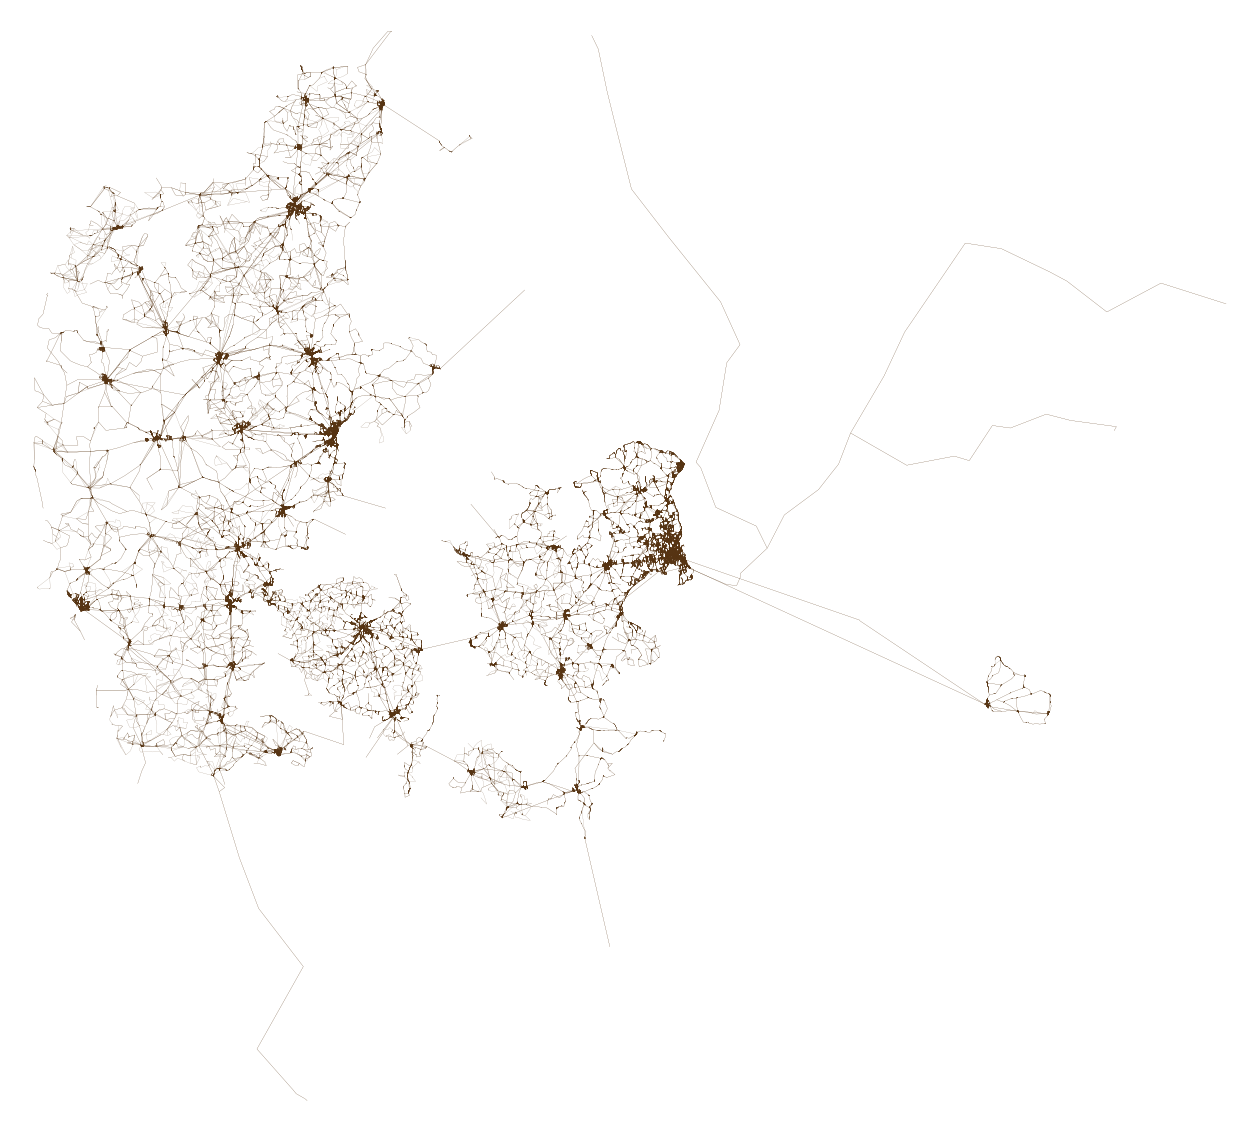

In [18]:
# Get a list of node weights and give nodes without weight a 0
node_weights = [int(data.get('weight', 0)) for _, data in G_walks.nodes(data=True)]
node_weights = pd.Series(node_weights) #osmnx expects pandas Series

# Normalize weights to a reasonable range for plotting, add a constant to show less travelled nodes
normalized_weights = ((3000+node_weights)-node_weights.mean())/node_weights.std()

fig, ax = ox.plot_graph(G_walks,
               figsize = (16,16),
                show=False,
                close=False,
                node_color='darkorange',
                #node_edgecolor="white",
                node_size=normalized_weights,
                node_zorder=10,
                edge_color='#522F0D',
                edge_alpha=0.8,
                edge_linewidth = 0.1,
                bgcolor='None',
                #bbox= bbox_,
               #bgcolor='black'
              
             );

In [19]:
stops_gdf = gp.GeoDataFrame(
    stops_df, geometry=gp.points_from_xy(stops_df.stop_lon, stops_df.stop_lat), crs= 'EPSG:4326').to_crs('EPSG: 3857')
stops_gdf

,weight,stop_name,stop_lat,stop_lon,geometry
stop_id,,,,,


In [20]:
density_df = pd.read_csv('data/meta_density_2020.csv')
density_df = gp.GeoDataFrame(
    density_df, geometry=gp.points_from_xy(density_df.longitude, density_df.latitude), crs= 'EPSG:4326')

In [21]:
density_df = density_df.drop(["longitude", "latitude"], axis=1).rename(columns={'dnk_general_2020':'density'}).to_crs('EPSG:3857')#.to_crs('EPSG:25832')

In [22]:
denmark_gdf = gp.read_file("data/shapely/shapefile.zip!dk_1km.shp").to_crs('EPSG:3857')#.to_crs('EPSG:25832')

In [23]:
denmark_density = gp.sjoin(density_df, denmark_gdf, predicate = 'within')

In [24]:
denmark_density = denmark_density.drop(["CELLCODE", "EOFORIGIN", "NOFORIGIN", "index_right"], axis = 1)

In [25]:
station_density = gp.sjoin_nearest(denmark_density, stops_gdf, max_distance=5000, distance_col='distance')

In [26]:
station_density_coords = station_density.to_crs('EPSG:4326')

In [27]:
# for reference: max density is 618
start = 0
station_density_coords[(station_density_coords['distance'] > 1000) & (station_density_coords['stop_name'] != 'malmö c')].sort_values('density', ascending=False).iloc[start:start+10]

,density,geometry,index_right,weight,stop_name,stop_lat,stop_lon,distance


In [100]:
#coordinate = [54.82278 , 8.85028]
#point_coord = Point(coordinate)

# create a dataframe with needed attributes and required geometry column
#df = {'GWU': ['Dept Geography'], 'geometry': [point_coord]}

# Convert shapely object to a geodataframe 
#point = gp.GeoDataFrame(df, geometry='geometry', crs ="EPSG:4326")

In [42]:
gp.read_file("data/shapely/shapefile.zip!dk_1km.shp").crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Eur

In [103]:
gp.sjoin(point, denmark_gdf, predicate = 'within')

,GWU,geometry,index_right,CELLCODE,EOFORIGIN,NOFORIGIN


In [247]:
shapefile = "data/DAGI/kommuneinddeling/kommuneinddeling.shp"
kommuner_df = gp.read_file(shapefile)
kommuner_df['kommunekod'] = kommuner_df['kommunekod'].astype(int)
kommuner_df.head()

,objectid,id_lokalid,id_namespa,status,geometrist,virkningfr,virkningti,virkningsa,forretning,registreri,...,landekode,skala,kommunekod,lau1vaerdi,udenforkom,regionskod,regionslok,udtraeksda,gmlid,geometry
0,1284412,389183,http://data.gov.dk/dagi,vedtaget,endelig,20181102000000,None,Geodatastyrelsen,matrikulærAjourføring,20181102081410.437,...,DK,1:10.000,665,665,f,1082,389101,2020-04-20,dagi.389183,MULTIPOLYGON Z (((446115.180 6250956.630 0.000...
1,1284617,389199,http://data.gov.dk/dagi,vedtaget,endelig,20181107000000,None,Geodatastyrelsen,matrikulærAjourføring,20181107121715.346,...,DK,1:10.000,810,810,f,1081,389098,2020-04-20,dagi.389199,"POLYGON Z ((556389.890 6342937.290 0.000, 5563..."
2,1284619,389206,http://data.gov.dk/dagi,vedtaget,endelig,20181107000000,None,Geodatastyrelsen,matrikulærAjourføring,20181107121715.346,...,DK,1:10.000,851,851,f,1081,389098,2020-04-20,dagi.389206,MULTIPOLYGON Z (((557400.690 6323373.320 0.000...
3,1284689,389175,http://data.gov.dk/dagi,vedtaget,endelig,20181108000000,None,Geodatastyrelsen,FOTAjourføring,20181108130916.952,...,DK,1:10.000,607,607,f,1083,389102,2020-04-20,dagi.389175,MULTIPOLYGON Z (((537517.320 6152061.430 0.000...
4,1287002,389140,http://data.gov.dk/dagi,vedtaget,endelig,20190101000000,None,Geodatastyrelsen,matrikulærAjourføring,20190107122901.497,...,DK,1:10.000,316,316,f,1085,389100,2020-04-20,dagi.389140,MULTIPOLYGON Z (((674151.550 6184820.700 0.000...


In [248]:
municipality_centroids = kommuner_df.to_crs('EPSG:3035').set_index('kommunekod').centroid #equal area projection
municipality_centroids

kommunekod
665    POINT (4215266.790 3711496.646)
810    POINT (4328442.135 3791502.202)
851    POINT (4318758.111 3767816.970)
607    POINT (4301043.922 3607699.776)
316    POINT (4422852.329 3618463.061)
                    ...               
480    POINT (4336491.865 3601642.292)
791    POINT (4284208.126 3706718.802)
846    POINT (4317728.350 3732157.849)
461    POINT (4344563.570 3586754.382)
707    POINT (4360197.508 3706618.245)
Length: 99, dtype: geometry

In [250]:
m_centroid_dict = municipality_centroids.to_dict()

In [231]:
municipality_flow = municipality_flow.rename(columns={"StartStopPointNr": "origin_id", "SlutStopPointNr": "destination_id", "SUM_of_Personrejser": "flow"})
municipality_flow

,origin_id,destination_id,flow
0,101,101,2034272
1,101,147,302461
2,101,151,64730
3,101,153,28013
4,101,155,11250
...,...,...,...
6624,860,840,103
6625,860,846,81
6626,860,849,536
6627,860,851,10809


In [267]:
# Fill all municipality pairs not found with 0 flow
ids = pd.unique(municipality_flow[['origin_id', 'destination_id']].values.ravel('K'))

new_df = pd.DataFrame({'origin_id': np.repeat(ids, len(ids)), 'destination_id': np.tile(ids, len(ids))})

# Merge new_df with df to get the corresponding flow values
municipality_flow = pd.merge(new_df, municipality_flow, on=['origin_id', 'destination_id'], how='left')

# Replace NaN values in the flow column with 0
municipality_flow['flow'].fillna(0, inplace=True)

municipality_flow

,origin_id,destination_id,flow
0,101,101,2034272.0
1,101,147,302461.0
2,101,151,64730.0
3,101,153,28013.0
4,101,155,11250.0
...,...,...,...
8644,860,840,103.0
8645,860,846,81.0
8646,860,849,536.0
8647,860,851,10809.0


In [114]:
election_df = pd.read_csv('data/cleaned_election_data.csv')

In [226]:
municipality_population = election_df.groupby('Kommune').sum('Persons18')['Persons18'].reset_index().rename(columns = {'Persons18': 'population'})


In [297]:
# Convert Kommune column to same data type as origin_id and destination_id
municipality_flow['origin_id'] = municipality_flow['origin_id'].astype(int)
municipality_flow['destination_id'] = municipality_flow['destination_id'].astype(int)

# Merge with origin
df_combined = pd.merge(municipality_flow, municipality_population, how='left', 
              left_on='origin_id', right_on='Kommune')
df_combined = df_combined.rename(columns = {'population': 'origin_population'})
df_combined = df_combined.drop(columns=['Kommune'])  # drop the extra Kommune column

# Merge with destination
df_combined = pd.merge(df_combined, municipality_population, how='left', 
              left_on='destination_id', right_on='Kommune')
df_combined = df_combined.rename(columns = {'population': 'destination_population'})
df_combined = df_combined.drop(columns=['Kommune'])  # drop the extra Kommune column
df_combined['flow'] = df_combined['flow'].astype(int)

In [298]:
df_combined['distance'] = df_combined.apply(lambda row: m_centroid_dict[int(row['origin_id'])].distance(m_centroid_dict[int(row['destination_id'])]), axis=1)
df_combined['origin_centroid'] = df_combined['origin_id'].map(m_centroid_dict)
df_combined['destination_centroid'] = df_combined['destination_id'].map(m_centroid_dict)

In [302]:
df_combined

,origin_id,destination_id,flow,origin_population,destination_population,distance,origin_centroid,destination_centroid
0,101,101,2034272,421003,421003,0.000000,POINT (4481691.894126311 3621889.2995568854),POINT (4481691.894126311 3621889.2995568854)
1,101,147,302461,421003,74261,1928.733717,POINT (4481691.894126311 3621889.2995568854),POINT (4479804.868403825 3622288.232727931)
2,101,151,64730,421003,34450,13727.516325,POINT (4481691.894126311 3621889.2995568854),POINT (4469322.345000779 3627842.362540466)
3,101,153,28013,421003,23405,9383.836684,POINT (4481691.894126311 3621889.2995568854),POINT (4473166.871010945 3617967.5178458984)
4,101,155,11250,421003,10233,11283.080096,POINT (4481691.894126311 3621889.2995568854),POINT (4486351.491569957 3611613.3057790007)
...,...,...,...,...,...,...,...,...
8644,860,840,103,48996,21642,71730.608512,POINT (4324564.759417644 3817086.929558276),POINT (4310203.738286054 3746808.6166195218)
8645,860,846,81,48996,31766,85203.786819,POINT (4324564.759417644 3817086.929558276),POINT (4317728.349662352 3732157.8486148156)
8646,860,849,536,48996,29151,48406.566826,POINT (4324564.759417644 3817086.929558276),POINT (4290897.073093693 3782306.4377642856)
8647,860,851,10809,48996,162672,49610.946698,POINT (4324564.759417644 3817086.929558276),POINT (4318758.110959423 3767816.970496552)


In [309]:
o_vars = df_combined['origin_population'].values.flatten()
d_vars = df_combined['destination_population'].values.flatten()
flows = df_combined['flow'].values.flatten()
d_matrix = df_combined['distance'].values.reshape(-1,1)

# compute model
model = Gravity(flows, o_vars, d_vars, d_matrix, 'exp')

# print out results
print("Model parameters:", model.params)
print("Standard errors:", model.std_err)
print("Log-likelihood:", model.llf)
print("AIC:", model.AIC)

Model parameters: [-1.22145741e+01  1.03811142e+00  1.03403618e+00 -7.61594779e-05]
Standard errors: [4.09812623e-03 2.77960017e-04 2.78069815e-04 2.43114279e-08]
Log-likelihood: -2539621.2778013945
AIC: 5079250.555602789


/tmp/ipykernel_241/2759264191.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = df_combined.pivot('origin_id', 'destination_id', 'flow')


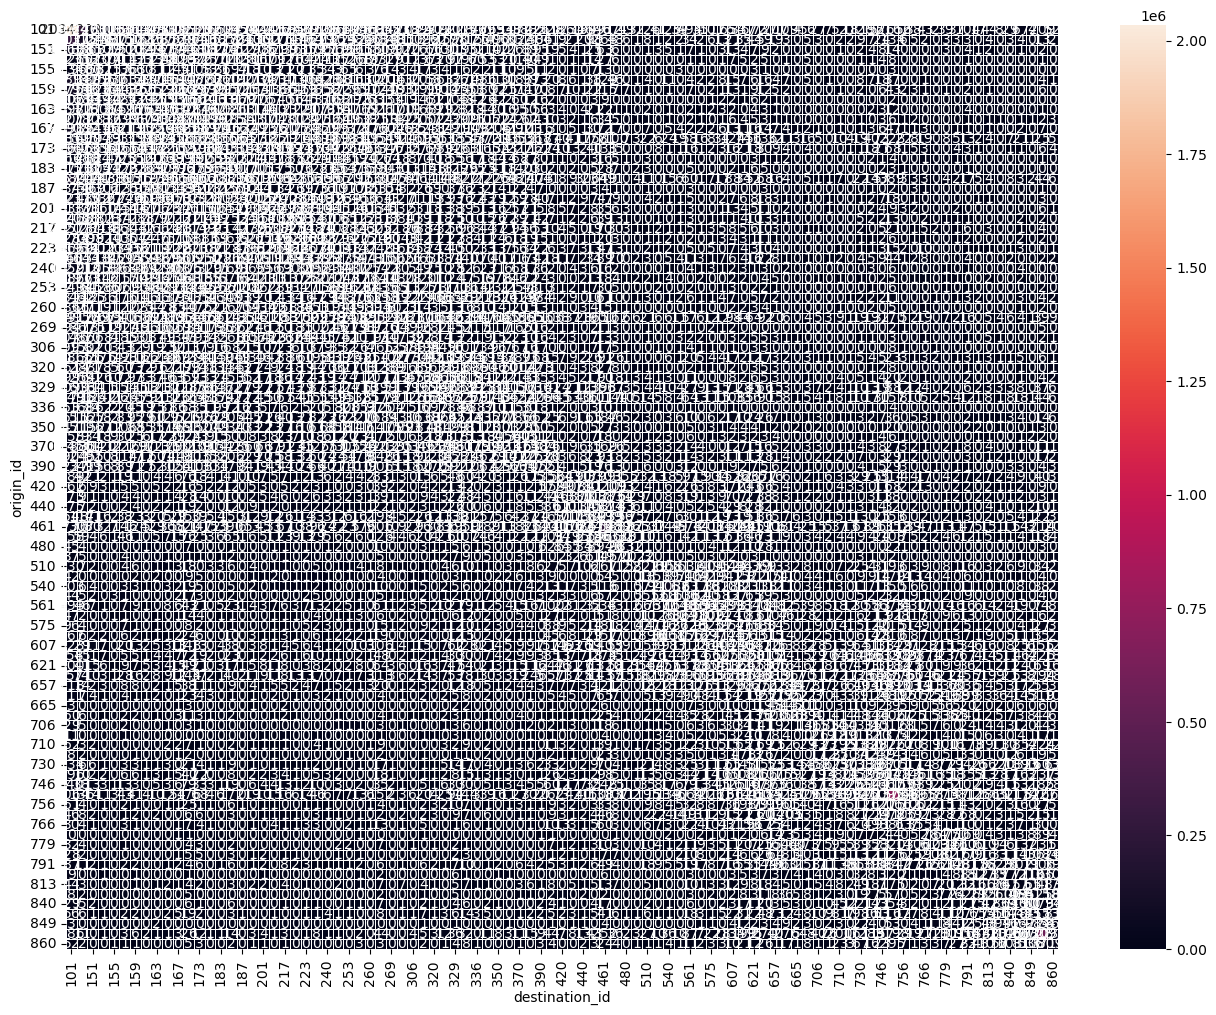

In [315]:
# Pivot the data
pivot_df = df_combined.pivot('origin_id', 'destination_id', 'flow')

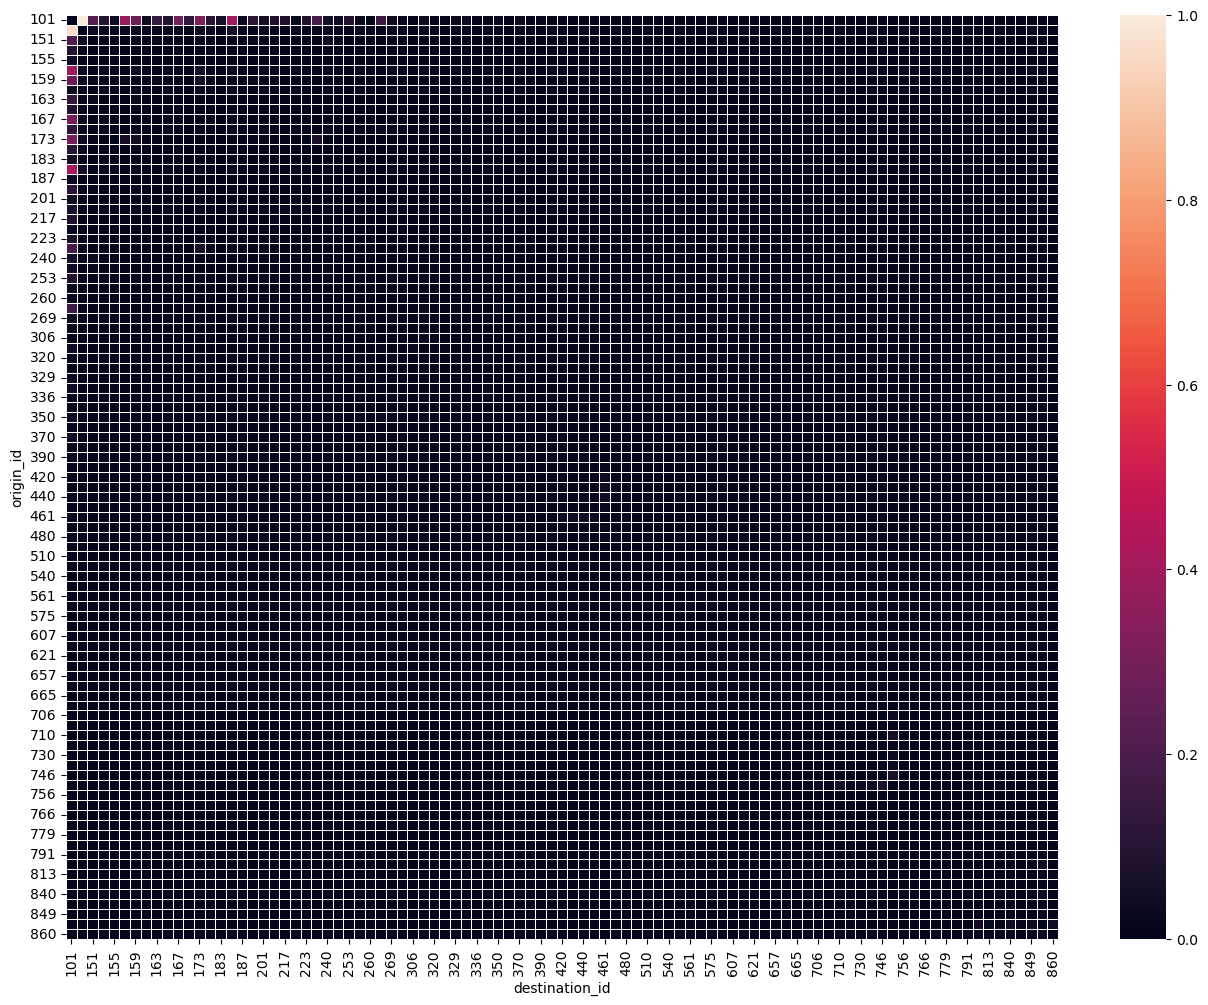

In [317]:
# Set diagonal to 0 (no self-flows)
np.fill_diagonal(pivot_df.values, 0)

# Normalize the flow
pivot_df = pivot_df / pivot_df.values.max()

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(pivot_df, linewidths=.5, ax=ax)
plt.show()